In [9]:
from rlcard.utils.utils import remove_illegal
import numpy as np
import random
import collections
import enum
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import collections
import rlcard
import os
import datetime
import pickle
from rlcard.agents.nfsp_agent import ReservoirBuffer, DQNAgent
from rlcard.agents import RandomAgent, LeducholdemHumanAgent as HumanAgent
from rlcard.utils import get_device, set_seed, tournament, reorganize, Logger, plot_curve, remove_illegal, print_card


class CFRAgent:
    def __init__(self, env, model_name, model_path='./cfr_model'):
        self.env = env
        self.model_path = model_path
        self.strategy = collections.defaultdict(list)
        self.average_strategy = collections.defaultdict(np.array)
        self.regrets = collections.defaultdict(np.array)
        self.iteration = 0
        self.use_raw = False
        self.model_name = model_name
    
    def save(self):
        with open(os.path.join('./', self.model_path, self.model_name + '-cfr-' + 'avg-strategy.pkl'), 'wb') as f:
            pickle.dump(agent.average_strategy, f)

        with open(os.path.join(self.model_path, self.model_name + '-cfr-' + 'strategy.pkl'), 'wb') as f:
            pickle.dump(agent.strategy, f)

        with open(os.path.join(self.model_path, self.model_name + '-cfr-' + 'regrets.pkl'), 'wb') as f:
            pickle.dump(agent.regrets, f)
            
    def load(self):
        with open(os.path.join(self.model_path, self.model_name + '-cfr-' + 'avg-strategy.pkl'), 'rb') as f:
            self.average_strategy = pickle.load(f)
        
        with open(os.path.join(self.model_path, self.model_name + '-cfr-' + 'strategy.pkl'), 'rb') as f:
            self.strategy = pickle.load(f)
                  
        with open(os.path.join(self.model_path, self.model_name + '-cfr-' + 'regrets.pkl'), 'rb') as f:
            self.regrets = pickle.load(f)

    def get_state(self, player_id):
        state = self.env.get_state(player_id)
        
        # returns a tuple, current observation encoded as a string and a list of possible actions
        return state['obs'].tostring(), list(state['legal_actions'].keys())

    
    def train(self):
        # train every player
        self.iteration += 1
        self.env.reset()
        
        for player_id in range(self.env.num_players):
            reach_probs = np.ones(self.env.num_players)
            self.cfr(reach_probs, player_id)
        
        self.update_strategy()
            
    def get_strategy_for_actions(self, obs, actions, strategy):
        if obs not in strategy.keys():
            # initialize to uniform distribution
            action_probs = np.array([1.0/self.env.num_actions for _ in range(self.env.num_actions)]) # todo refactor this
            self.strategy[obs] = action_probs
        else:
            action_probs = strategy[obs]
        action_probs = remove_illegal(action_probs, actions)
        return action_probs

    def update_strategy(self):
        ''' Update policy based on the current regrets
        '''
        for obs in self.regrets:
            self.strategy[obs] = self.regret_matching(obs)
            
    def eval_step(self, state):
        ''' Given a state, predict action based on average policy
        Args:
            state (numpy.array): State representation
        Returns:
            action (int): Predicted action
            info (dict): A dictionary containing information
        '''
        probs = self.get_strategy_for_actions(state['obs'].tostring(), list(state['legal_actions'].keys()), self.average_strategy)
        action = np.random.choice(len(probs), p=probs)

        info = {}
        info['probs'] = {state['raw_legal_actions'][i]: float(probs[list(state['legal_actions'].keys())[i]]) for i in range(len(state['legal_actions']))}

        return action, info

    
    def regret_matching(self, obs):
        regret = self.regrets[obs]
        positive_regret_sum = sum([r for r in regret if r > 0])
        
        action_probs = np.zeros(self.env.num_actions)
        if positive_regret_sum > 0:
            for action in range(self.env.num_actions):
                action_probs[action] = max(0.0, regret[action] / positive_regret_sum)
        else:
            for action in range(self.env.num_actions):
                action_probs[action] = 1.0 / self.env.num_actions
        return action_probs

        
    def cfr(self, reach_probs, player_id):
        if self.env.is_over():
            return self.env.get_payoffs()
        
        current_player = self.env.get_player_id()
        
        action_utilities = {} # expected payoff for every action?
        infostate_utility = np.zeros(self.env.num_players) # get a handle on this, counterfactual reach probability?
        
        obs, legal_actions = self.get_state(current_player)
        
        # get the strategy for possible actions
        action_probs = self.get_strategy_for_actions(obs, legal_actions, self.strategy)
        
        for action in legal_actions:
            # recalculate reach probability for this action
            action_prob = action_probs[action]
            new_reach_probs = reach_probs.copy()
            new_reach_probs[current_player] *= action_prob
            
            # traverse util you reach game node z, this will terminate at env.is_over()
            self.env.step(action)
            utility = self.cfr(new_reach_probs, player_id)
            self.env.step_back()
            
            # counterfactual reach probability equals the sum of all reach probabilities
            infostate_utility += action_prob * utility
            action_utilities[action] = utility
            
        if not current_player == player_id:
            return infostate_utility
        
        player_prob = reach_probs[current_player]
        counterfactual_prob = (np.prod(reach_probs[:current_player]) *
                                np.prod(reach_probs[current_player + 1:]))
        player_state_utility = infostate_utility[current_player]
        
        # initialize records if they don't exist
        if obs not in self.regrets:
            self.regrets[obs] = np.zeros(self.env.num_actions)
        if obs not in self.average_strategy:
            self.average_strategy[obs] = np.zeros(self.env.num_actions)
        
        # calculate counterfactual regret for every action
        for action in legal_actions:
            action_prob = action_probs[action]
            
            # counterfactual regret is the utility of the action taking by the player - total utility of all actions 
            regret = counterfactual_prob * (action_utilities[action][current_player] - player_state_utility)
            self.regrets[obs][action] += regret
            self.average_strategy[obs][action] += self.iteration * player_prob * action_prob
        return infostate_utility
    



class AveragePolicyAgent(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.env = env
        self.fc1 = nn.Linear(self.env.state_shape[0][0], 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, self.env.num_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return F.log_softmax(x, dim=-1)


class AveragePolicyAgent(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.env = env
        self.fc1 = nn.Linear(self.env.state_shape[0][0], 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, self.env.num_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return F.log_softmax(x, dim=-1)


class NFSPAgent:
    def __init__(self, env, device):
        self.use_raw = False
        self._device = device
        
        self.eta = 0.1
        
        self.sample_size = 32
        
        self._rl_agent = DQNAgent(
            state_shape=env.state_shape[0],
            num_actions=env.num_actions,
            mlp_layers=[64, 64],
            device=device)
        self._m_sl = ReservoirBuffer(20000)
        self._avg_policy_agent = AveragePolicyAgent(env)
        self._avg_policy_agent.to(device)
        self._avg_policy_optimizer = torch.optim.Adam(self._avg_policy_agent.parameters(), lr=0.005)
        self.device = device
        self.model_path = './models'
        self.epochs = 0
        
    def eval_step(self, state):

        obs = state['obs']
        legal_actions = list(state['legal_actions'].keys())
        if np.random.rand() < self.eta:
            action, info = self._rl_agent.eval_step(state)
        else:
            action_probs = self._get_action_probs_from_policy(obs)
            action_probs = remove_illegal(action_probs, legal_actions)
            action = np.random.choice(len(action_probs), p=action_probs)
            info = {}
            info['probs'] = {state['raw_legal_actions'][i]: float(action_probs[list(state['legal_actions'].keys())[i]]) for i in range(len(state['legal_actions']))}
        
        return action, info
    
    def save(self, model_name):
        torch.save({
            'avg_policy': self._avg_policy_agent.state_dict(),
            'q_policy_estimator': self._rl_agent.q_estimator.qnet.state_dict(),
            'q_target_estimator': self._rl_agent.target_estimator.qnet.state_dict()
        }, self.model_path + '/' + model_name)

    def load(self, model_name):
        checkpoint = torch.load(self.model_path + '/' + model_name)
        self._avg_policy_agent.load_state_dict(checkpoint['avg_policy'])
        self._rl_agent.q_estimator.qnet.load_state_dict(checkpoint['q_policy_estimator'])
        self._rl_agent.target_estimator.qnet.load_state_dict(checkpoint['q_target_estimator'])
    
    def step(self, state):

        obs = state['obs']
        legal_actions = list(state['legal_actions'].keys())
        if np.random.rand() < self.eta:
            # make the rl agent act

            action = self._rl_agent.step(state)
            one_hot = np.zeros(env.num_actions)
            one_hot[action] = 1

            self._m_sl.add((obs, one_hot))
        else:
            # avg policy agent
            action_probs = self._get_action_probs_from_policy(obs)
            action_probs = remove_illegal(action_probs, legal_actions)
            action = np.random.choice(len(action_probs), p=action_probs)

        return action
    
    def train_avg_policy(self):
        if len(self._m_sl) < self.sample_size:
            return None
        
        sample = self._m_sl.sample(self.sample_size)
        
        self._avg_policy_agent.zero_grad()
        self._avg_policy_agent.eval()
        
        infostates = []
        action_probs = []
        for transition in sample:
            infostates.append(transition[0])
            action_probs.append(transition[1])
        
        infostates = torch.from_numpy(np.array(infostates)).float().to(self.device)
        eval_action_probs = torch.from_numpy(np.array(action_probs)).float().to(self.device)
        #eval_action_probs = eval_action_probs.long()
        log_action_probs = self._avg_policy_agent(infostates)
        #criterion = nn.MSELoss()
        #loss = criterion(log_action_probs, eval_action_probs)
        loss = -(eval_action_probs * log_action_probs).sum(dim=-1).mean()
        loss.backward()
        
        self._avg_policy_optimizer.step()
        self._avg_policy_agent.eval()
        loss_total = loss.item()
        return loss_total
    
    def _get_action_probs_from_policy(self, obs):
        obs = torch.from_numpy(obs).float().to(self.device)
        
        with torch.no_grad():
            action_probs = self._avg_policy_agent(obs)
        
        action_probs = action_probs.cpu().numpy()
        return np.exp(action_probs)
        

In [10]:
EPISODES = 200000
EVALUATE_EVERY = 1000
EVALUATION_GAMES = 2000
GAME = 'leduc-holdem'

Training start time = 2021-08-18 21:00:29.769026
iteration 0

----------------------------------------
  timestep     |  192
  reward       |  -0.0115
----------------------------------------
iteration 1000

----------------------------------------
  timestep     |  192192
  reward       |  0.8925
----------------------------------------
iteration 2000

----------------------------------------
  timestep     |  384192
  reward       |  0.87575
----------------------------------------
iteration 3000

----------------------------------------
  timestep     |  576192
  reward       |  0.8305
----------------------------------------
iteration 4000

----------------------------------------
  timestep     |  768192
  reward       |  0.77975
----------------------------------------
iteration 5000

----------------------------------------
  timestep     |  960192
  reward       |  0.8035
----------------------------------------
iteration 6000

----------------------------------------
  timeste

iteration 55000

----------------------------------------
  timestep     |  10560192
  reward       |  0.8205
----------------------------------------
iteration 56000

----------------------------------------
  timestep     |  10752192
  reward       |  0.806
----------------------------------------
iteration 57000

----------------------------------------
  timestep     |  10944192
  reward       |  0.914
----------------------------------------
iteration 58000

----------------------------------------
  timestep     |  11136192
  reward       |  0.74475
----------------------------------------
iteration 59000

----------------------------------------
  timestep     |  11328192
  reward       |  0.80175
----------------------------------------
iteration 60000

----------------------------------------
  timestep     |  11520192
  reward       |  0.822
----------------------------------------
iteration 61000

----------------------------------------
  timestep     |  11712192
  reward  

iteration 110000

----------------------------------------
  timestep     |  21120192
  reward       |  0.853
----------------------------------------
iteration 111000

----------------------------------------
  timestep     |  21312192
  reward       |  0.8475
----------------------------------------
iteration 112000

----------------------------------------
  timestep     |  21504192
  reward       |  0.90025
----------------------------------------
iteration 113000

----------------------------------------
  timestep     |  21696192
  reward       |  0.83175
----------------------------------------
iteration 114000

----------------------------------------
  timestep     |  21888192
  reward       |  0.7965
----------------------------------------
iteration 115000

----------------------------------------
  timestep     |  22080192
  reward       |  0.795
----------------------------------------
iteration 116000

----------------------------------------
  timestep     |  22272192
  

iteration 164000

----------------------------------------
  timestep     |  31488192
  reward       |  0.7655
----------------------------------------
iteration 165000

----------------------------------------
  timestep     |  31680192
  reward       |  0.731
----------------------------------------
iteration 166000

----------------------------------------
  timestep     |  31872192
  reward       |  0.814
----------------------------------------
iteration 167000

----------------------------------------
  timestep     |  32064192
  reward       |  0.8675
----------------------------------------
iteration 168000

----------------------------------------
  timestep     |  32256192
  reward       |  0.76575
----------------------------------------
iteration 169000

----------------------------------------
  timestep     |  32448192
  reward       |  0.88475
----------------------------------------
iteration 170000

----------------------------------------
  timestep     |  32640192
  

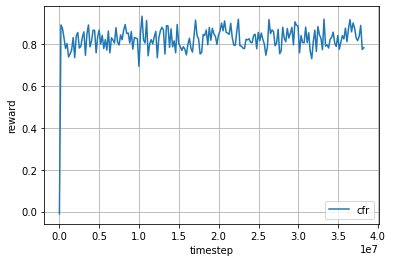

In [11]:
# train cfr


env = rlcard.make(GAME, config={'seed': 0, 'allow_step_back':True})
eval_env = rlcard.make(GAME, config={'seed': 0})

set_seed(1)

agent = CFRAgent(env, 'leduc', 'models')
eval_env.set_agents([agent, RandomAgent(num_actions=env.num_actions)])

print(f'Training start time = {datetime.datetime.now()}')

with Logger('./leduc') as logger:
    for episode in range(EPISODES):
        agent.train()
        if episode % EVALUATE_EVERY == 0:
            print(f'iteration {episode}')
            logger.log_performance(env.timestep, tournament(eval_env, EVALUATION_GAMES)[0])
    
    csv_path, fig_path = logger.csv_path, logger.fig_path
plot_curve(csv_path, fig_path, 'cfr')
            
print(f'Training end time = {datetime.datetime.now()}')


Logs saved in ./leduc


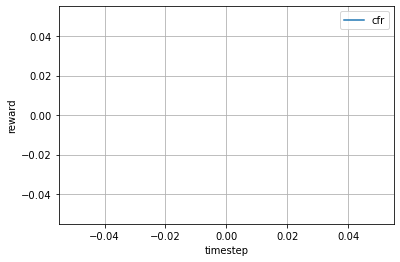

In [8]:
with Logger('./leduc') as logger:
    csv_path, fig_path = logger.csv_path, logger.fig_path
plot_curve(csv_path, fig_path, 'cfr')

--> Running on the GPU

----------------------------------------
  timestep     |  1
  reward       |  0.37525
----------------------------------------
INFO - Step 100, rl-loss: 1.1231166124343872
INFO - Copied model parameters to target network.
INFO - Step 1100, rl-loss: 0.29753172397613525
INFO - Copied model parameters to target network.
INFO - Step 1273, rl-loss: 1.17448699474334727
----------------------------------------
  timestep     |  8586
  reward       |  0.91
----------------------------------------
INFO - Step 2100, rl-loss: 1.03228902816772466
INFO - Copied model parameters to target network.
INFO - Step 2615, rl-loss: 1.75271606445312542
----------------------------------------
  timestep     |  18287
  reward       |  0.88625
----------------------------------------
INFO - Step 3100, rl-loss: 1.53649425506591836
INFO - Copied model parameters to target network.
INFO - Step 3922, rl-loss: 1.24653983116149934
----------------------------------------
  timestep     |  27

INFO - Step 37100, rl-loss: 4.0835275650024417
INFO - Copied model parameters to target network.
INFO - Step 38100, rl-loss: 1.3293745517730713
INFO - Copied model parameters to target network.
INFO - Step 38316, rl-loss: 5.8989858627319346
----------------------------------------
  timestep     |  263177
  reward       |  0.9445
----------------------------------------
INFO - Step 39100, rl-loss: 2.9135904312133793
INFO - Copied model parameters to target network.
INFO - Step 39952, rl-loss: 2.2846164703369142
----------------------------------------
  timestep     |  273761
  reward       |  0.96925
----------------------------------------
INFO - Step 40100, rl-loss: 4.6686601638793945
INFO - Copied model parameters to target network.
INFO - Step 41100, rl-loss: 4.1418018341064455
INFO - Copied model parameters to target network.
INFO - Step 41499, rl-loss: 2.4759092330932617
----------------------------------------
  timestep     |  284129
  reward       |  1.0805
------------------

INFO - Step 76100, rl-loss: 3.3157298564910898
INFO - Copied model parameters to target network.
INFO - Step 77100, rl-loss: 2.2169950008392334
INFO - Copied model parameters to target network.
INFO - Step 77167, rl-loss: 1.7377542257308967
----------------------------------------
  timestep     |  525400
  reward       |  0.94925
----------------------------------------
INFO - Step 78100, rl-loss: 2.7943379878997803
INFO - Copied model parameters to target network.
INFO - Step 78749, rl-loss: 2.3548793792724615
----------------------------------------
  timestep     |  536039
  reward       |  1.0305
----------------------------------------
INFO - Step 79100, rl-loss: 3.96376609802246124
INFO - Copied model parameters to target network.
INFO - Step 80100, rl-loss: 0.94896930456161553
INFO - Copied model parameters to target network.
INFO - Step 80360, rl-loss: 3.5062856674194336
----------------------------------------
  timestep     |  546775
  reward       |  0.874
-----------------

INFO - Step 115100, rl-loss: 3.7957315444946295
INFO - Copied model parameters to target network.
INFO - Step 115950, rl-loss: 1.17614245414733895
----------------------------------------
  timestep     |  788448
  reward       |  0.96675
----------------------------------------
INFO - Step 116100, rl-loss: 2.5411086082458496
INFO - Copied model parameters to target network.
INFO - Step 117100, rl-loss: 3.3113503456115723
INFO - Copied model parameters to target network.
INFO - Step 117508, rl-loss: 3.3526988029479985
----------------------------------------
  timestep     |  799000
  reward       |  0.977
----------------------------------------
INFO - Step 118100, rl-loss: 5.2198276519775394
INFO - Copied model parameters to target network.
INFO - Step 119048, rl-loss: 7.8175115585327155
----------------------------------------
  timestep     |  809407
  reward       |  1.05825
----------------------------------------
INFO - Step 119100, rl-loss: 3.2572436332702637
INFO - Copied mode

INFO - Step 191100, rl-loss: 2.9437980651855476
INFO - Copied model parameters to target network.
INFO - Step 192100, rl-loss: 3.0911478996276855
INFO - Copied model parameters to target network.
INFO - Step 192387, rl-loss: 1.7093067169189453
----------------------------------------
  timestep     |  1305373
  reward       |  0.89175
----------------------------------------
INFO - Step 193100, rl-loss: 0.8674354553222656
INFO - Copied model parameters to target network.
INFO - Step 193935, rl-loss: 2.9858970642089844
----------------------------------------
  timestep     |  1315839
  reward       |  1.0015
----------------------------------------
INFO - Step 194100, rl-loss: 4.16415786743164154
INFO - Copied model parameters to target network.
INFO - Step 195100, rl-loss: 2.8712935447692877
INFO - Copied model parameters to target network.
INFO - Step 195494, rl-loss: 1.99725508689880375
----------------------------------------
  timestep     |  1326303
  reward       |  1.0325
-----

INFO - Step 267100, rl-loss: 2.8190014362335205
INFO - Copied model parameters to target network.
INFO - Step 268100, rl-loss: 1.38651299476623547
INFO - Copied model parameters to target network.
INFO - Step 268510, rl-loss: 3.4914007186889657
----------------------------------------
  timestep     |  1820695
  reward       |  1.0575
----------------------------------------
INFO - Step 269100, rl-loss: 0.8058529496192932
INFO - Copied model parameters to target network.
INFO - Step 270023, rl-loss: 1.8320597410202026
----------------------------------------
  timestep     |  1831084
  reward       |  1.178
----------------------------------------
INFO - Step 270100, rl-loss: 1.7283072471618652
INFO - Copied model parameters to target network.
INFO - Step 271100, rl-loss: 4.5882587432861335
INFO - Copied model parameters to target network.
INFO - Step 271625, rl-loss: 1.9744039773941046
----------------------------------------
  timestep     |  1841756
  reward       |  1.06275
-------

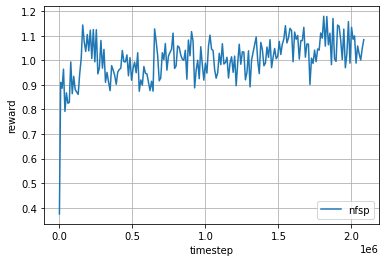

In [94]:
device = get_device()
# from rlcard.agents import NFSPAgent

env = rlcard.make(GAME, config={'seed': 0})

nfsp = NFSPAgent(env, device)
nfsp.eta = 0.9
# nfsp = NFSPAgent(num_actions=env.num_actions,
#                           state_shape=env.state_shape[0],
#                           hidden_layers_sizes=[64,64],
#                           q_mlp_layers=[64,64],
#                           device=device)

env.set_agents([nfsp, RandomAgent(num_actions=env.num_actions)])

# one episode
sl_loss = []
with Logger('./leduc-nfsp') as logger:
    for i in range(EPISODES):
        trajectories, payoffs = env.run(is_training=True) # requires a step method. Will populate the transition buffer m_sl
        trajectories = reorganize(trajectories, payoffs)

        for ts in trajectories[0]:
            #(state, action, reward, next_state, done) = tuple(ts)
            nfsp._rl_agent.feed(ts) # train the rl agent, populate the _m_rl buffer
            loss = nfsp.train_avg_policy()
            #nfsp.feed(ts)
        
#         nfsp.epochs += 1
        if i % EVALUATE_EVERY == 0:
            sl_loss.append(loss)
            logger.log_performance(env.timestep, tournament(env, EVALUATION_GAMES)[0])
        
#         if i % 100000 == 0:
#             nfsp.save('nfsp')
            
        
            
    csv_path, fig_path = logger.csv_path, logger.fig_path
    
plot_curve(csv_path, fig_path, 'nfsp')

# NFSP vs. CFR

In [95]:
nfsp.save('nfsp')

env = rlcard.make(GAME)
env.set_agents([nfsp, agent])

nfsp_wins = 0
cfr_wins = 0
ties = 0

def evaluate_games(a1, a2, env):
    env.set_agents([a1, a2])
    a1_wins = 0
    a2_wins = 0
    ties = 0
    episode_count = 0
    while episode_count != EVALUATION_GAMES:
        trajectories, payoffs = env.run(is_training=False)
        final_state = trajectories[0][-1]
        action_record = final_state['action_record']
        state = final_state['raw_obs']
        _action_list = []

        for i in range(1, len(action_record)+1):
            if action_record[-i][0] == state['current_player']:
                break
            _action_list.insert(0, action_record[-i])

        if payoffs[0] > 0:
            a1_wins += 1
        elif payoffs[0] == 0:
            ties += 1
        else:
            a2_wins += 1

        episode_count += 1
    
    return a1_wins, a2_wins, ties

print(f"nfsp wins, cfr wins, ties = {evaluate_games(nfsp, agent, env)}")


nfsp wins, cfr wins, ties = (1100, 678, 222)


# CFR vs. Rule Agent

In [96]:
# cfr vs. rule agent
from rlcard.models.leducholdem_rule_models import LeducHoldemRuleAgentV1

rule_agent = LeducHoldemRuleAgentV1()

env = rlcard.make(GAME)

print(f"rule wins, cfr wins, ties = {evaluate_games(rule_agent, agent, env)}")


rule wins, cfr wins, ties = (1036, 701, 263)


# CFR vs. Random

In [97]:
# cfr vs. random

from rlcard.agents import RandomAgent

random_agent = RandomAgent(env.num_actions)

env = rlcard.make(GAME)

print(f"random wins, cfr wins, ties = {evaluate_games(random_agent, agent, env)}")

random wins, cfr wins, ties = (595, 1297, 108)


# NFSP vs Rule

In [98]:
# nfsp vs. rule agent

rule_agent = LeducHoldemRuleAgentV1()

env = rlcard.make(GAME)

print(f"rule wins, nfsp wins, ties = {evaluate_games(rule_agent, nfsp, env)}")

rule wins, nfsp wins, ties = (885, 730, 385)


# NFSP vs Random

In [99]:
# nfsp vs. random agent

from rlcard.agents import RandomAgent

random_agent = RandomAgent(env.num_actions)

env = rlcard.make(GAME)

print(f"random wins, nfsp wins, ties = {evaluate_games(random_agent, nfsp, env)}")

random wins, nfsp wins, ties = (318, 1579, 103)


# CFR vs. Human Author

In [7]:
env = rlcard.make('leduc-holdem')
human_agent = HumanAgent(env.num_actions)
agent = CFRAgent(env, 'leduc', 'models')
agent.load()
env.set_agents([human_agent, agent])

print(">> Leduc Hold'em pre-trained model")

n_games = 10
total_games = 0
games_human_won = 0
games_cfr_won = 0
games_tied = 0

while (total_games != n_games):
    print(">> Start a new game")

    trajectories, payoffs = env.run(is_training=False)
    # If the human does not take the final action, we need to
    # print other players action
    final_state = trajectories[0][-1]
    action_record = final_state['action_record']
    state = final_state['raw_obs']
    _action_list = []
    for i in range(1, len(action_record)+1):
        if action_record[-i][0] == state['current_player']:
            break
        _action_list.insert(0, action_record[-i])
    for pair in _action_list:
        print('>> Player', pair[0], 'chooses', pair[1])

    # Let's take a look at what the agent card is
    print('===============     CFR Agent    ===============')
    print_card(env.get_perfect_information()['hand_cards'][1])

    print('===============     Result     ===============')
    if payoffs[0] > 0:
        print('You win {} chips!'.format(payoffs[0]))
        games_human_won += 1
    elif payoffs[0] == 0:
        print('It is a tie.')
        games_tied += 1
    else:
        print('You lose {} chips!'.format(-payoffs[0]))
        games_cfr_won += 1
    print('')
    total_games += 1

    input("Press any key to continue...")

print(f'Total score human, cfr, ties = {games_human_won, games_cfr_won, games_tied}')

>> Leduc Hold'em pre-trained model
>> Start a new game
>> Player 1 chooses raise

=============== Community Card ===============
┌─────────┐
│░░░░░░░░░│
│░░░░░░░░░│
│░░░░░░░░░│
│░░░░░░░░░│
│░░░░░░░░░│
│░░░░░░░░░│
│░░░░░░░░░│
└─────────┘
===============   Your Hand    ===============
┌─────────┐
│K        │
│         │
│         │
│    ♠    │
│         │
│         │
│        K│
└─────────┘
===============     Chips      ===============
Yours:   ++
Agent 1: ++++
=========== Actions You Can Choose ===========
0: call, 1: raise, 2: fold

>> You choose action (integer): 1
>> Player 1 chooses call

=============== Community Card ===============
┌─────────┐
│Q        │
│         │
│         │
│    ♠    │
│         │
│         │
│        Q│
└─────────┘
===============   Your Hand    ===============
┌─────────┐
│K        │
│         │
│         │
│    ♠    │
│         │
│         │
│        K│
└─────────┘
===============     Chips      ===============
Yours:   ++++++
Agent 1: ++++++
===========

>> You choose action (integer): 0
>> Player 0 chooses call
===============     CFR Agent    ===============
┌─────────┐
│K        │
│         │
│         │
│    ♥    │
│         │
│         │
│        K│
└─────────┘
===============     Result     ===============
It is a tie.

Press any key to continue...
>> Start a new game
>> Player 1 chooses raise

=============== Community Card ===============
┌─────────┐
│░░░░░░░░░│
│░░░░░░░░░│
│░░░░░░░░░│
│░░░░░░░░░│
│░░░░░░░░░│
│░░░░░░░░░│
│░░░░░░░░░│
└─────────┘
===============   Your Hand    ===============
┌─────────┐
│K        │
│         │
│         │
│    ♥    │
│         │
│         │
│        K│
└─────────┘
===============     Chips      ===============
Yours:   ++
Agent 1: ++++
=========== Actions You Can Choose ===========
0: call, 1: raise, 2: fold

>> You choose action (integer): 1
>> Player 1 chooses call

=============== Community Card ===============
┌─────────┐
│K        │
│         │
│         │
│    ♠    │
│         │
│         